In [274]:
import numpy as np
import pandas as pd
from datetime import datetime
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM,SimpleRNN
from tensorflow.keras.layers import Dropout

import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
pyoff.init_notebook_mode(connected=True)

In [236]:
location = (r"C:\Users\Tauseef\Desktop\shampoo_sales.csv")

In [237]:
data = pd.read_csv(location)

In [238]:
data.tail()

,Month,Sales
31,2022-03-08,407.6
32,2022-03-09,682.0
33,2022-03-10,475.3
34,2022-03-11,581.3
35,2022-03-12,646.9


In [239]:
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv(location, parse_dates=[0], index_col=0, date_parser=parser)
df.tail()

,Sales
Month,
2022-03-08,407.6
2022-03-09,682.0
2022-03-10,475.3
2022-03-11,581.3
2022-03-12,646.9


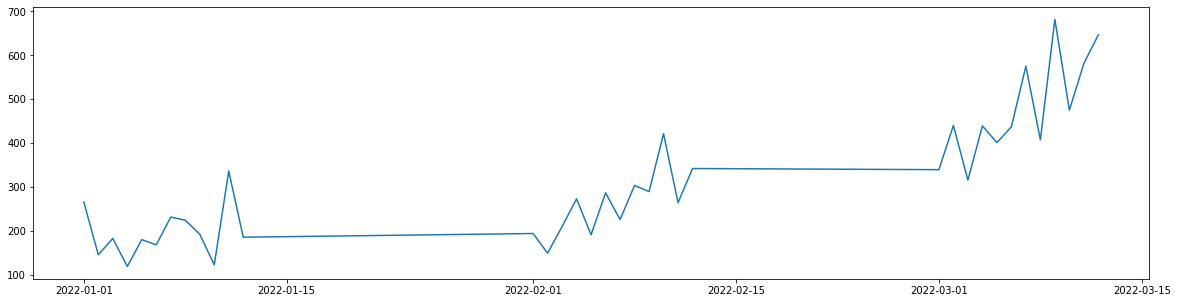

In [240]:
sales = df.iloc[:,0]
plt.figure(figsize=(20,5))
plt.plot(sales)

In [241]:
train = df

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

In [242]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [276]:
model = Sequential()
model.add(SimpleRNN (200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))

optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

In [277]:
history = model.fit_generator(generator,epochs=100,verbose=1)

Epoch 1/100
4/4 [==============================] - 0s 3ms/step - loss: 0.1079
Epoch 2/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 3/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 4/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0255
Epoch 5/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 6/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 7/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 8/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0100
Epoch 9/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 10/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0180
Epoch 11/100
4/4 [==============================] - 0s 2ms/step - loss: 0.0159
Epoch 12/100
4/4 [==============================] - 0s 3ms/step - loss: 0.0132
Epoch 13/100
4/4 [==============================] - 0s 3ms/st

In [278]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

plot_data = [
    go.Scatter(
        x=hist['epoch'],
        y=hist['loss'],
        name='loss'
    )
    
]

plot_layout = go.Layout(
        title='Training loss'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [325]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(24):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [329]:
add_dates = [df.index[-1] + DateOffset(month=4, day=x) for x in range(0,25) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df.columns)


In [330]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),index=future_dates[-24:].index, columns=['Prediction'])

df_proj = pd.concat([df,df_predict], axis=1)

# df_proj.tail(12)

In [331]:
plot_data = [
    go.Scatter(
        x=df_proj.index,
        y=df_proj['Sales'],
        name='actual'
    ),
    go.Scatter(
        x=df_proj.index,
        y=df_proj['Prediction'],
        name='prediction'
    )
]

plot_layout = go.Layout(
        title='Shampoo sales prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)